In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import AEMpy library
import aempy

# Import Extra libraries
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, datetime
import seaborn as sns

In [3]:
system = aempy.System()

In [4]:
# Request error logs
errorlogs = system.log_error()

Request: http://localhost:4502/system/console/slinglog/tailer.txt?tail=10000&grep=*&name=/logs/error.log


In [5]:
# There is a builtin parsing in AEMpy to automatically convert logs to pandas dataframe
dfErrors = system.error_log_to_df(errorlogs)

In [6]:
# What is the distribution of the message levels?
dfErrors.groupby("level")["level"].count()

level
ERROR      45
INFO     9841
WARN       46
Name: level, dtype: int64

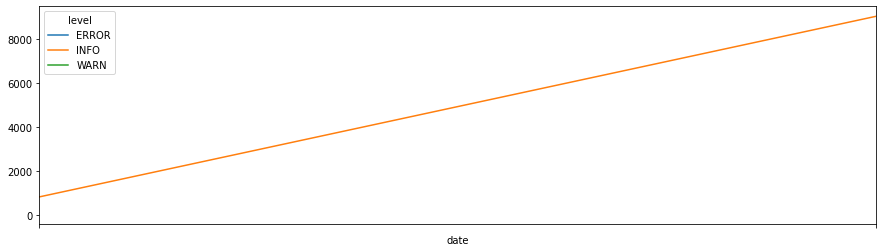

In [7]:
# Plot the messages with 1 min frequency
system.plot(dfErrors)

In [8]:
# Read a local log file
dfErrors = system.error_logfile_to_df("error.log.2020-07-29")

In [9]:
# What is the distribution of the message levels?
dfErrors.groupby("level")["level"].count()

level
ERROR    1248
INFO     6308
WARN     2444
Name: level, dtype: int64

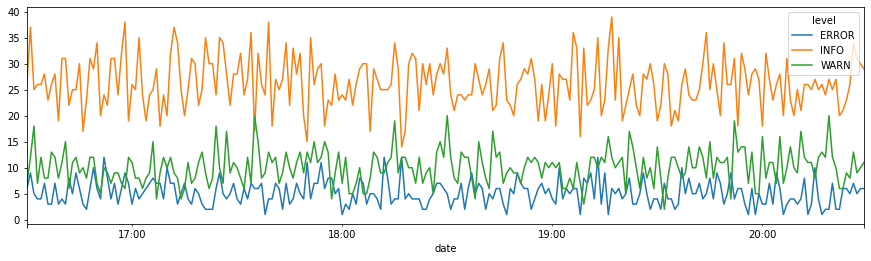

In [10]:
# Plot the messages with 1 min frequency
system.plot(dfErrors)

In [11]:
# Filter to keep only errors
df_ERROR = dfErrors[dfErrors["level"] == "ERROR"]

In [304]:
df_ERROR.head(10)

,date,level,class,message
6,2020-07-29 16:30:16,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."
9,2020-07-29 16:30:18,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."
12,2020-07-29 16:30:25,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."
17,2020-07-29 16:30:29,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."
19,2020-07-29 16:30:35,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."
37,2020-07-29 16:30:57,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."
39,2020-07-29 16:31:00,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."
45,2020-07-29 16:31:04,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."
48,2020-07-29 16:31:08,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."
52,2020-07-29 16:31:11,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."


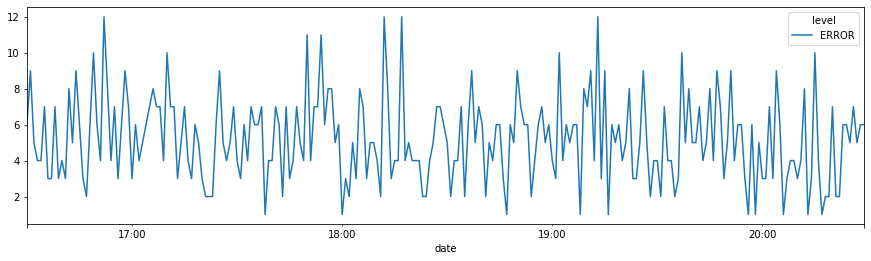

In [13]:
# Plot the ERROR messages with 1 min frequency
# See available frequencies here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
system.plot(df_ERROR, "1min") # "1ms")

In [86]:
# Amount of errors per minute
t = (df_ERROR.assign(counter = 1)
             .set_index('date')
             .groupby([pd.Grouper(freq="1min"), 'level']).sum()
             .squeeze()
             .unstack())

t.head()

level,ERROR
date,
2020-07-29 16:30:00,6
2020-07-29 16:31:00,9
2020-07-29 16:32:00,5
2020-07-29 16:33:00,4
2020-07-29 16:34:00,4


In [155]:
# Technical conversion to Data Frame
df_logs = pd.DataFrame({"logdate":t.index.to_pydatetime(), 
        "error_count":t['ERROR'].values}, columns=["logdate", "error_count"])
df_logs.head()

,logdate,error_count
235,2020-07-29 20:25:00,5
236,2020-07-29 20:26:00,7
237,2020-07-29 20:27:00,5
238,2020-07-29 20:28:00,6
239,2020-07-29 20:29:00,6


In [189]:
prediction_length = 10

In [292]:
train_ds = []
for x in range(0,len(df_logs),prediction_length):
    log_window = df_logs.loc[x:x+prediction_length]
    ts = pd.Timestamp(log_window['logdate'].iloc[0], freq="min")
    train_ds.append({'target':log_window['error_count'].astype('float').values, 'start':ts})

In [293]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions

In [296]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=prediction_length,
    context_length=100,
    freq="1min",
    trainer=Trainer(ctx="cpu", epochs=50, learning_rate=0.001, hybridize=True, num_batches_per_epoch=200,),
)

In [297]:
predictor = estimator.train(train_ds)

  0%|          | 0/200 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 200/200 [00:01<00:00, 197.97it/s, epoch=50/50, avg_epoch_loss=2.51]


In [301]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=train_ds[-2:],  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [302]:
forecasts = list(forecast_it)
tss = list(ts_it)

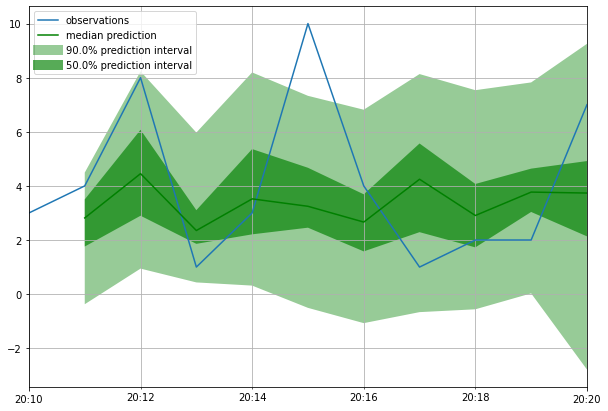

In [303]:
# Plot the prediction
plot_length = 150 
prediction_intervals = (50.0, 90.0)
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
tss[0][-plot_length:].plot(ax=ax)  # plot the time series
forecasts[0].plot(prediction_intervals=prediction_intervals, color='g')
plt.grid(which="both")
plt.legend(legend, loc="upper left")
plt.show()